# <center>Capstone Project - The Battle of Neighborhoods</center>
### <center>Opening an artisanal coffee shop in Toronto</center>

## Table of contents
* [Introduction/Business Problem](#intro)
* [Data Preparation](#datpr)
* [Data Analysis](#datan)
* [Results and Discussion](#resul)
* [Conclusion](#concl)

##### Introduction/Business Problem: <a name="intro"></a>
    
A (hypothetical) client wishes to open a new artisanal coffee shop, which will be their foray into the Canadian market. They plan to offer a cozy and comfortable space for both business workers and casual visitors to sit down, while also offering a take-out option. There will be a strong emphasis on high quality coffee at a reasonable cost. 

One of the most important success drivers for a coffee shop business is its location and hence they are looking to leverage data to identify an ideal Toronto neighborhood that will broadly satisfy the following criteria:
* A strong demand – they feel that they test well with office/business workers (white collar) and may also work well with college students (colleges in vicinity a plus, but not mandatory)
* A robust population – the preference is for a neighborhood with a large population (especially working age), with ideally a high average per capita earning
* Limited competition – the location should have a low density of coffee shops, but not so low that it indicates a lack of viability. Something in the middle is preferable


Lets import the necessary libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analysis

import requests # library to handle requests
from requests import get

!pip install geocoder
import geocoder 

!pip install geopandas
!pip install geopy

!conda install -c conda-forge folium=0.5.0 --yes # Install Folium
import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt  

     |████████████████████████████████| 102kB 16.5MB/s ta 0:00:01
     |████████████████████████████████| 931kB 21.4MB/s eta 0:00:01
     |████████████████████████████████| 10.4MB 20.1MB/s eta 0:00:01
     |████████████████████████████████| 1.8MB 34.5MB/s eta 0:00:01
     |████████████████████████████████| 14.7MB 34.7MB/s eta 0:00:01MB 34.7MB/s eta 0:00:01
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    altair-4.1.0               |         

### Data Preparation <a name="datpr"></a>

Extract Toronto Open Data Files (Neighborhood & Neighborhood Profiles) for processing 

In [2]:
torODdemo = pd.read_csv('https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/ef0239b1-832b-4d0b-a1f3-4153e53b189e?format=csv')
torODneigh = pd.read_csv('https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/a083c865-6d60-4d1d-b6c6-b0c8a85f9c15?format=csv&projection=4326')

# Select only relevant rows related to working population and average income from Neighborhood data  
income_only = (torODdemo['Category'] == 'Income') & (torODdemo['Characteristic'].str.contains("Total income: Average amount"))
pop_only = (torODdemo['Category'] == 'Population') & (torODdemo['Characteristic'].str.contains("Working Age"))

neigh_avg_income = torODdemo[income_only]
neigh_pop_inc = torODdemo[pop_only]

neigh_pop_income = pd.concat([neigh_avg_income,neigh_pop_inc],ignore_index=True)
neigh_pop_income.head()

# Drop irrelevant columns that will not be used
neigh_pop_income.drop(columns=['_id','Category','Topic','Data Source','Characteristic','City of Toronto'],inplace=True)

# Transpose rows and columns to get avg income for each neighborhood as rows
tn_pop_income = neigh_pop_income.T
tn_pop_income.rename_axis('Neighborhood',inplace=True)
tn_pop_income.rename(columns={0:'Income',1:'Work Age Pop'},inplace=True)
tn_pop_income.head()

,Income,Work Age Pop
Neighborhood,,
Agincourt North,"30,414","11,305"
Agincourt South-Malvern West,"31,825","9,965"
Alderwood,"47,709","5,220"
Annex,"112,766","15,040"
Banbury-Don Mills,"67,757","10,810"


Cleanup Neighborhood profiles dataframe to fix some discrepancies in the open dataset and drop columns that are not relevant 

In [3]:
# Cleaning up Neighborhood profiles data
torODneigh.drop(columns=['_id','AREA_ID','AREA_ATTR_ID','PARENT_AREA_ID','AREA_SHORT_CODE','AREA_LONG_CODE','AREA_DESC','X','Y','OBJECTID','Shape__Area','Shape__Length','geometry'],inplace=True)
torODneigh.rename(columns={'AREA_NAME':'Neighborhood','LATITUDE':'Latitude','LONGITUDE':'Longitude'},inplace=True)

splitter = torODneigh['Neighborhood'].str.split('(',expand=True)
torODneigh['Neighborhood'] = splitter[0]
torODneigh['Neighborhood'] = torODneigh['Neighborhood'].str.rstrip()

# Fixing four value mismatches in Neighborhood data 
torODneigh['Neighborhood'].replace({'Cabbagetown-South St.James Town':'Cabbagetown-South St. James Town',
                                    'Mimico':'Mimico (includes Humber Bay Shores)',
                                    'North St.James Town':'North St. James Town',
                                    'Weston-Pellam Park':'Weston-Pelham Park'},inplace=True)
torODneigh.head()

,Neighborhood,Longitude,Latitude
0,Wychwood,-79.425515,43.676919
1,Yonge-Eglinton,-79.403590,43.704689
2,Yonge-St.Clair,-79.397871,43.687859
3,York University Heights,-79.488883,43.765736
4,Yorkdale-Glen Park,-79.457108,43.714672


Merge selected columns from Neighborhood and Neighborhood Profiles dataset into a dataframe for Foursquare lookup and further analysis later on

In [4]:
torODneigh.set_index('Neighborhood',inplace=True)
tor_neigh_enh = pd.merge(torODneigh,tn_pop_income,left_index=True, right_index=True)

# Export to CSV for use if required 
tor_neigh_enh.to_csv('tordataenh.csv')

tor_neigh_enh.head()

,Longitude,Latitude,Income,Work Age Pop
Neighborhood,,,,
Wychwood,-79.425515,43.676919,"54,460","6,420"
Yonge-Eglinton,-79.403590,43.704689,"89,330","5,860"
Yonge-St.Clair,-79.397871,43.687859,"114,174","5,960"
York University Heights,-79.488883,43.765736,"29,958","12,290"
Yorkdale-Glen Park,-79.457108,43.714672,"38,527","5,860"


Use Folium to display 140 Toronto Neighborhoods on a map of Toronto

In [6]:
# Getting Toronto coordinates from Nominatim
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.exc import GeocoderServiceError
from geopy.exc import GeopyError

# Use geocoder only to get Toronto,ON coordinates 
locator = Nominatim(user_agent="arxGeocoder")
geolocator = RateLimiter(locator.geocode, min_delay_seconds=1, max_retries=0)

yyzloc = geolocator('Toronto, Ontario, Canada',timeout=None)

# Generating map of Toronto using folium
map_toronto = folium.Map(location=[yyzloc.latitude, yyzloc.longitude], zoom_start=11)

tor_neigh_enh.reset_index(inplace=True)

# Add markers to map
for lat, lng, neighborhood in zip(tor_neigh_enh['Latitude'], tor_neigh_enh['Longitude'], tor_neigh_enh['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Setup Foursquare API credentials and also set categories to query

In [7]:
#Setting up Foursquare credentials
CLIENT_ID = '33SCCYRTKM2435UIGC52SX2NKT5ELO0E5QVIECBCRIQE2IJB' # your Foursquare ID
CLIENT_SECRET = '0QZEB51NYB0KQLXUAXTUXFSPCH4GOSK40PSSYRAXW0PLB1ZU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

# Only select categories - Coffee Shop, Cafe, Office and Colleges for Foursquare query
sel_venues = {'Coffee Shop':'4bf58dd8d48988d1e0931735',
              'Café':'4bf58dd8d48988d16d941735',
              'Office':'4bf58dd8d48988d124941735',
              'College & University':'4d4b7105d754a06372d81259'
             }

Your credentails:
CLIENT_ID: 33SCCYRTKM2435UIGC52SX2NKT5ELO0E5QVIECBCRIQE2IJB
CLIENT_SECRET:0QZEB51NYB0KQLXUAXTUXFSPCH4GOSK40PSSYRAXW0PLB1ZU


Create function to get category types

In [8]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Create function to get nearby venues of selected categories

In [9]:
def getNearbyCoffeeVenues(names, latitudes, longitudes, radius=1000,cat=sel_venues):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        for key in cat:
            
            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                LIMIT,
                sel_venues[key])
            
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
        
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                    'Neighborhood Latitude', 
                    'Neighborhood Longitude', 
                    'Venue', 
                    'Venue Latitude', 
                    'Venue Longitude', 
                    'Venue Category']
    
    return(nearby_venues)

Call Foursquare function for all 140 neighborhoods in Toronto

In [10]:
# Calling function for all values in Toronto DataFrame

LIMIT = 100

toronto_venues = getNearbyCoffeeVenues(names=tor_neigh_enh['Neighborhood'],
                                   latitudes=tor_neigh_enh['Latitude'],
                                   longitudes=tor_neigh_enh['Longitude']
                                  )

Wychwood
Yonge-Eglinton
Yonge-St.Clair
York University Heights
Yorkdale-Glen Park
Lambton Baby Point
Lansing-Westgate
Lawrence Park North
Lawrence Park South
Leaside-Bennington
Little Portugal
Long Branch
Malvern
Maple Leaf
Markland Wood
Milliken
Mimico (includes Humber Bay Shores)
Morningside
Moss Park
Mount Dennis
Mount Olive-Silverstone-Jamestown
Mount Pleasant East
Mount Pleasant West
New Toronto
Newtonbrook East
Newtonbrook West
Niagara
North Riverdale
North St. James Town
O'Connor-Parkview
Oakridge
Oakwood Village
Old East York
Palmerston-Little Italy
Parkwoods-Donalda
Pelmo Park-Humberlea
Playter Estates-Danforth
Pleasant View
Princess-Rosethorn
Regent Park
Rexdale-Kipling
Rockcliffe-Smythe
Roncesvalles
Rosedale-Moore Park
Rouge
Runnymede-Bloor West Village
Rustic
Scarborough Village
South Parkdale
South Riverdale
St.Andrew-Windfields
Steeles
Stonegate-Queensway
Tam O'Shanter-Sullivan
Taylor-Massey
The Beaches
Thistletown-Beaumond Heights
Thorncliffe Park
Trinity-Bellwoods
Unive

Save Foursquare return data to csv for future use, if required

In [12]:
print(toronto_venues.shape)
toronto_venues.to_csv('Toronto_Cafe_List.csv')
toronto_venues.head()

(4684, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wychwood,43.676919,-79.425515,CocoaLatte,43.681768,-79.425158,Café
1,Wychwood,43.676919,-79.425515,Baker and Scone,43.681614,-79.426075,Café
2,Wychwood,43.676919,-79.425515,Contra Cafe,43.669107,-79.426105,Café
3,Wychwood,43.676919,-79.425515,Krave Coffee,43.680740,-79.429417,Coffee Shop
4,Wychwood,43.676919,-79.425515,Starbucks,43.671530,-79.421400,Coffee Shop


Remove a neighborhood from dataframe that returned no results from Foursquare

In [13]:
# Dropping row for Newtonbrook West as it does not return any rows from FourSquare
tor_neigh_enh.drop(tor_neigh_enh[tor_neigh_enh.Neighborhood == 'Newtonbrook West'].index,inplace=True)

Create a dataframe with only Coffee Shops from Foursquare data for further analysis

In [14]:
tor_vis_coffee = toronto_venues[(toronto_venues['Venue Category']=='Coffee Shop') | (toronto_venues['Venue Category']=='Café')]
tor_vis_coffee.reset_index(inplace=True)

tor_vis_coffee.drop(columns=['index','Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue','Venue Category'],inplace=True)
tor_vis_coffee.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Venue Latitude,Venue Longitude
0,43.681768,-79.425158
1,43.681614,-79.426075
2,43.669107,-79.426105
3,43.680740,-79.429417
4,43.671530,-79.421400


Create a dataframe with only Office locations from Foursquare data for further analysis

In [15]:
tor_vis_college = toronto_venues[toronto_venues['Venue Category']=='Office']
tor_vis_college.reset_index(inplace=True)
tor_vis_college.drop(columns=['index','Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue Category'],inplace=True)
tor_vis_college.head()

,Venue,Venue Latitude,Venue Longitude
0,Camp Wahanowin Toronto Office,43.705018,-79.405610
1,LSBF Canada,43.706365,-79.400756
2,Woori Education & Immigration Consulting,43.706918,-79.400280
3,Royal LePage Condo Showroom,43.704663,-79.408436
4,Canadian Tire Home Office,43.704766,-79.398349


Lets use the coffee shops locations to generate a heatmap onto a map that contains neighborhood markers and office locations. As expected a high concentration of coffee shops and offices are in the downtown area. However, there are potential locations within GTA which neighborhood clustering will help identify.

In [16]:
# Create a map of Toronto ON using manual latitude and longitude values for best centering
tor_lat_long = [43.703762,-79.340986]

map_tor = folium.Map(location=tor_lat_long, zoom_start=11)

from folium import plugins

# Add neighborhood markers to the map
for lat, lng, neighborhood in zip(tor_neigh_enh['Latitude'], tor_neigh_enh['Longitude'], tor_neigh_enh['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tor)  
    

# Add office locations to map as white markers
for lat, lng, cat in zip(tor_vis_college['Venue Latitude'], tor_vis_college['Venue Longitude'], tor_vis_college['Venue']):
    label = '{}'.format(cat)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='#FFFFFF',
        fill=True,
        fill_color='#FFFFFF',
        fill_opacity=0.6,
        parse_html=False).add_to(map_tor)  

# Generate a heatmap with Coffee Shop data to show popular locations 
tv_data = tor_vis_coffee.values.tolist()
map_tor.add_child(plugins.HeatMap(data=tv_data))

# Add a legend for the map
legend_html =   '''
                <div style="position: fixed; 
                            bottom: 50px; right: 50px; width: 140px; height: 110px; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            ">&nbsp; <center><b>Legend</b></center> <br>
                              &nbsp; Neighborhoods &nbsp; <i class="fa fa-circle fa-1x" style="color:blue"></i><br>
                              &nbsp; Offices &nbsp; <i class="fa fa-circle fa-1x" style="color:#FFFFFF"></i>
                </div>
                ''' 

map_tor.get_root().html.add_child(folium.Element(legend_html))

map_tor

### Data Analysis <a name="datan"></a>

Lets look at how many venues were returned for each neighborhood from Foursquare

In [17]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt North,9,9,9,9,9,9
Agincourt South-Malvern West,19,19,19,19,19,19
Alderwood,15,15,15,15,15,15
Annex,170,170,170,170,170,170
Banbury-Don Mills,13,13,13,13,13,13
Bathurst Manor,5,5,5,5,5,5
Bay Street Corridor,355,355,355,355,355,355
Bayview Village,12,12,12,12,12,12
Bayview Woods-Steeles,10,10,10,10,10,10


Use one hot encoding to prep data for K-Means clustering

In [18]:
# One hot encoding for Toronto DataFrame

toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# Move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Adult Education Center,Advertising Agency,American Restaurant,Arepa Restaurant,Art Gallery,Automotive Shop,Bakery,Bank,Bar,...,Salon / Barbershop,School,Shopping Mall,Sorority House,Student Center,Supermarket,Tea Room,Tech Startup,Trade School,University
0,Wychwood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Wychwood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Wychwood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Wychwood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Wychwood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Grouping neighborhoods and identifying mean values for venues

In [19]:
# Grouping by Neighborhoods

toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Adult Education Center,Advertising Agency,American Restaurant,Arepa Restaurant,Art Gallery,Automotive Shop,Bakery,Bank,Bar,...,Salon / Barbershop,School,Shopping Mall,Sorority House,Student Center,Supermarket,Tea Room,Tech Startup,Trade School,University
0,Agincourt North,0.0,0.000000,0.000000,0.0,0.000000,0.0000,0.111111,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Agincourt South-Malvern West,0.0,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000
2,Alderwood,0.0,0.066667,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000
3,Annex,0.0,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.005882,0.017647,0.000000,0.017647,0.005882,0.000000,0.023529
4,Banbury-Don Mills,0.0,0.000000,0.000000,0.0,0.076923,0.0000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000
5,Bathurst Manor,0.0,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Bay Street Corridor,0.0,0.002817,0.000000,0.0,0.002817,0.0000,0.000000,0.002817,0.0,...,0.0,0.000000,0.000000,0.000000,0.022535,0.000000,0.019718,0.002817,0.005634,0.028169
7,Bayview Village,0.0,0.083333,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Bayview Woods-Steeles,0.0,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.100000
9,Bedford Park-Nortown,0.0,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.153846,0.000000,0.000000


Identifying most common venues for each neighborhood and merging top 10 with neighborhood info for further analysis

In [20]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [21]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt North,Coffee Shop,Office,College Academic Building,Bakery,Business Service,College Classroom,University,College Quad,College Engineering Building,College Football Field
1,Agincourt South-Malvern West,Office,Café,Coffee Shop,College Classroom,College Science Building,College Bookstore,College Academic Building,College Cafeteria,Student Center,College Theater
2,Alderwood,Coffee Shop,Office,Café,College Classroom,College Baseball Diamond,General College & University,College Cafeteria,Advertising Agency,Student Center,Community College
3,Annex,Café,Coffee Shop,Office,College Academic Building,College Library,General College & University,College Administrative Building,University,College Arts Building,College Residence Hall
4,Banbury-Don Mills,Café,Coffee Shop,Art Gallery,Office,Trade School,Cosmetics Shop,College Quad,College Engineering Building,College Football Field,College Gym


Use Elbow method to identify the optimal K value for K-Means clustering

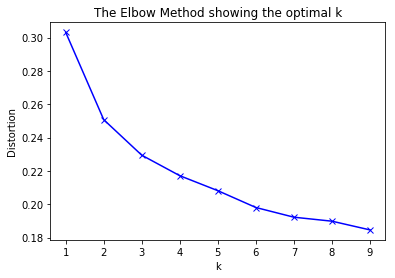

In [22]:
from sklearn import metrics
from scipy.spatial.distance import cdist

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

dist = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters = k).fit(toronto_grouped_clustering)
    dist.append(sum(np.min(cdist(toronto_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / toronto_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, dist, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Use Silhoutte method to verify/validate optimal K value for clustering

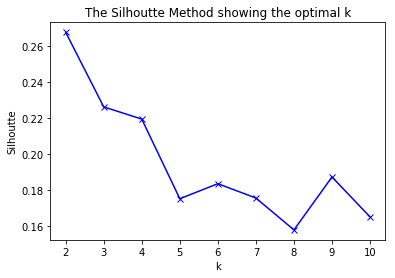

In [23]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 10
nK = range(2,11)

# Dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(toronto_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(toronto_grouped_clustering, labels, metric = 'euclidean'))

plt.plot(nK, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhoutte')
plt.title('The Silhoutte Method showing the optimal k')
plt.show()

K-Means clustering to identify neighborhood clusters

In [24]:
# Set number of clusters to value identified using elbow and silhoutte methods
kclusters = 2

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# Run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 1, 1, 0, 1, 0, 0, 1], dtype=int32)

Add cluster labels to the Neighborhood dataframe

In [25]:
# add clustering labels

try:
    neighborhoods_venues_sorted.drop(columns=['Cluster Labels'],inplace=True)
except:
    print('Column does not exist!')
    
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = tor_neigh_enh

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

#toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)
toronto_merged.head() # check the last columns!

Column does not exist!


,index,Neighborhood,Longitude,Latitude,Income,Work Age Pop,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Wychwood,-79.425515,43.676919,"54,460","6,420",1,Café,Coffee Shop,American Restaurant,Dessert Shop,College Gym,College Rec Center,General College & University,College Residence Hall,College Engineering Building,College Football Field
1,1,Yonge-Eglinton,-79.403590,43.704689,"89,330","5,860",0,Office,Coffee Shop,Café,College Academic Building,Tech Startup,General College & University,Tea Room,Coworking Space,Student Center,Advertising Agency
2,2,Yonge-St.Clair,-79.397871,43.687859,"114,174","5,960",0,Office,Coffee Shop,Café,College Academic Building,Campaign Office,College Classroom,General College & University,Pharmacy,Shopping Mall,Trade School
3,3,York University Heights,-79.488883,43.765736,"29,958","12,290",0,Office,Coffee Shop,Café,Automotive Shop,Fraternity House,College Residence Hall,College Engineering Building,College Football Field,College Gym,College History Building
4,4,Yorkdale-Glen Park,-79.457108,43.714672,"38,527","5,860",0,Office,Coffee Shop,Café,General College & University,Trade School,Medical Center,Medical School,College Technology Building,College Communications Building,College Engineering Building


### Results and Discussion <a name="resul"></a>

Lets use Folium to visualize clusters on a map and a heatmap of coffee shops to add context. When zooming into the map, its clear that most Cluster 0 neighborhoods fall on the fringes of areas with higher coffee shop density (or underserved areas). This indicates that they contain viable locations and will be subject of further inquiry.

In [26]:
# Create map of Toronto, ON 
map_clusters = folium.Map(location=tor_lat_long, zoom_start=11)

# set color scheme for the clusters
rainbow = ['#ffffff','#000000']

# Add cluster markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1.0).add_to(map_clusters)

# Add heatmap for coffee shops in Toronto to map
tv_data = tor_vis_coffee.values.tolist()
map_clusters.add_child(plugins.HeatMap(data=tv_data))

# Add legend to the map
legend_html =   '''
                <div style="position: fixed; 
                            bottom: 50px; right: 50px; width: 140px; height: 110px; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            ">&nbsp; <center><b>Legend</b></center> <br>
                              &nbsp; Cluster 0 &nbsp; <i class="fa fa-circle fa-1x" style="color:#000000"></i><br>
                              &nbsp; Cluster 1 &nbsp; <i class="fa fa-circle fa-1x" style="color:#ffffff"></i>
                </div>
                ''' 

map_clusters.get_root().html.add_child(folium.Element(legend_html))

       
map_clusters

Examine Cluster 0 for patterns. This cluster seems promising as it includes offices as the most popular venie with indications of coffee shop viability.

In [29]:
cluster0 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(3, toronto_merged.shape[1]))]]
cluster0

,Neighborhood,Latitude,Income,Work Age Pop,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Yonge-Eglinton,43.704689,"89,330","5,860",0,Office,Coffee Shop,Café,College Academic Building,Tech Startup,General College & University,Tea Room,Coworking Space,Student Center,Advertising Agency
2,Yonge-St.Clair,43.687859,"114,174","5,960",0,Office,Coffee Shop,Café,College Academic Building,Campaign Office,College Classroom,General College & University,Pharmacy,Shopping Mall,Trade School
3,York University Heights,43.765736,"29,958","12,290",0,Office,Coffee Shop,Café,Automotive Shop,Fraternity House,College Residence Hall,College Engineering Building,College Football Field,College Gym,College History Building
4,Yorkdale-Glen Park,43.714672,"38,527","5,860",0,Office,Coffee Shop,Café,General College & University,Trade School,Medical Center,Medical School,College Technology Building,College Communications Building,College Engineering Building
6,Lansing-Westgate,43.754271,"72,371","7,590",0,Office,Coworking Space,Café,College Gym,College & University,College Communications Building,College Engineering Building,College Football Field,College History Building,College Hockey Rink
11,Long Branch,43.592362,"47,384","4,705",0,Office,Café,Coffee Shop,Coworking Space,Tech Startup,College Gym,College Hockey Rink,College Communications Building,College Engineering Building,College Football Field
22,Mount Pleasant West,43.704435,"57,039","17,100",0,Office,Coffee Shop,Café,College Academic Building,Tech Startup,General College & University,School,Tea Room,Coworking Space,Student Center
30,Oakridge,43.697408,"26,793","6,050",0,Office,Café,College Rec Center,Lawyer,Medical Center,College Administrative Building,General College & University,Coffee Shop,University,College Hockey Rink
31,Oakwood Village,43.688566,"39,803","9,535",0,Office,Café,Tech Startup,Coffee Shop,College Library,University,College Communications Building,College Engineering Building,College Football Field,College Gym
32,Old East York,43.696781,"53,315","4,035",0,Office,Coffee Shop,College Classroom,Café,Student Center,College Academic Building,College Library,General College & University,College Communications Building,College Engineering Building


Examine Cluster 1 for patterns. The most prevalant venues are coffee shops or cafes which does not work well for our criteria.

In [30]:
cluster1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(3, toronto_merged.shape[1]))]]
cluster1

,Neighborhood,Latitude,Income,Work Age Pop,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Wychwood,43.676919,"54,460","6,420",1,Café,Coffee Shop,American Restaurant,Dessert Shop,College Gym,College Rec Center,General College & University,College Residence Hall,College Engineering Building,College Football Field
5,Lambton Baby Point,43.657420,"76,629","3,310",1,Café,Coffee Shop,Office,Advertising Agency,High School,College Library,General College & University,College Quad,College Engineering Building,College Football Field
7,Lawrence Park North,43.730060,"111,730","5,980",1,Café,Office,Coffee Shop,University,College Arts Building,Deli / Bodega,Student Center,Tea Room,Tech Startup,College Baseball Diamond
8,Lawrence Park South,43.717212,"169,203","5,870",1,Café,Coffee Shop,Office,College Academic Building,Bakery,General College & University,Law School,College Track,College Theater,College Communications Building
9,Leaside-Bennington,43.703797,"125,564","6,455",1,Coffee Shop,Café,Office,College Classroom,College Engineering Building,Student Center,Medical Center,Medical School,General College & University,College Library
10,Little Portugal,43.647536,"45,737","9,385",1,Café,Coffee Shop,Office,Tech Startup,Advertising Agency,Coworking Space,College Rec Center,General College & University,College Classroom,Event Space
12,Malvern,43.803658,"29,573","17,865",1,Café,General College & University,Coffee Shop,College Communications Building,College Engineering Building,College Football Field,College Gym,College History Building,College Hockey Rink,College Lab
13,Maple Leaf,43.715574,"37,108","4,110",1,Coffee Shop,College Classroom,Office,University,College Quad,College Communications Building,College Engineering Building,College Football Field,College Gym,College History Building
14,Markland Wood,43.633542,"62,378","3,600",1,Coffee Shop,Office,Café,General College & University,College Academic Building,Trade School,Advertising Agency,Concert Hall,College Math Building,College Engineering Building
15,Milliken,43.820691,"28,085","10,565",1,Café,Coffee Shop,University,College Communications Building,College Engineering Building,College Football Field,College Gym,College History Building,College Hockey Rink,College Lab


Cluster 0 seems to fit the bill as the most popular venues are businesses/offices, which is the main demand driver and there are also coffee shops indicating viability and presence of colleges is an added bonus. Lets look closely at the first result Waterfron Communities, which ranked highest in the weighted average score. 

In [31]:
# Most interesting cluster is cluster 0 - Lets explore that further 

# Make a copy if cluster0 dataframe for further analysis
cluster0_explore = cluster0.sort_values(by=['Income','Work Age Pop'],ascending=False).reset_index()
cluster0_explore.drop(columns=['index'],inplace=True)

# Figure out income and population for each neighborhood in comparison to the mean for this cluster and create a rudimentary weighting
cluster0_explore['Mean Income'] = cluster0_explore['Income'].str.replace(',','').astype(int) / cluster0_explore['Income'].str.replace(',','').astype(int).mean()
cluster0_explore['Mean Pop'] = cluster0_explore['Work Age Pop'].str.replace(',','').astype(int) / cluster0_explore['Work Age Pop'].str.replace(',','').astype(int).mean()
cluster0_explore['Weight'] = (cluster0_explore['Mean Income'] * 3) + (cluster0_explore['Mean Pop'] * 2)

# Figure out density of coffee shops in neighborhood in comparison to working age population
tor_coffee_count = toronto_venues[(toronto_venues['Venue Category']=='Coffee Shop') | (toronto_venues['Venue Category']=='Café')].groupby('Neighborhood').count()
tor_coffee_count.rename(columns={'Neighborhood Latitude':'Cafe Count'},inplace=True)
tor_coffee_count.drop(columns=['Neighborhood Longitude','Venue','Venue Latitude','Venue Longitude','Venue Category'],inplace=True)
cluster0_explore = cluster0_explore.join(tor_coffee_count, on='Neighborhood')
cluster0_explore['Cafe Count'] = cluster0_explore['Cafe Count'].fillna(0).astype(int)
cluster0_explore['Density'] = cluster0_explore['Cafe Count'] / cluster0_explore['Work Age Pop'].str.replace(',','').astype(int) 

#tor_coffee_count = toronto_venues[(toronto_venues['Venue Category']=='Coffee Shop') | (toronto_venues['Venue Category']=='Café')]
#tor_vis_coffee.reset_index(inplace=True)

# Sort by weight descending to find the most likely neighborhood candidate for the coffee shop
cluster0_explore = cluster0_explore.sort_values(by=['Weight'],ascending=False).reset_index()
cluster0_explore.drop(columns=['index','Mean Income','Mean Pop','Cafe Count'],inplace=True)
cluster0_explore

,Neighborhood,Latitude,Income,Work Age Pop,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Weight,Density
0,Waterfront Communities-The Island,43.633880,"70,600","45,105",0,Office,Coffee Shop,Café,Tech Startup,College Academic Building,College Library,General College & University,Brewery,Coworking Space,Law School,14.642735,0.000576
1,Yonge-St.Clair,43.687859,"114,174","5,960",0,Office,Coffee Shop,Café,College Academic Building,Campaign Office,College Classroom,General College & University,Pharmacy,Shopping Mall,Trade School,8.960390,0.003859
2,Willowdale East,43.770602,"45,326","25,850",0,Office,Café,Coffee Shop,College Administrative Building,Business Service,College Classroom,Coworking Space,Advertising Agency,Student Center,Concert Hall,8.717830,0.000851
3,St.Andrew-Windfields,43.756246,"100,516","6,800",0,Office,College Academic Building,University,College Quad,College Classroom,College Communications Building,College Engineering Building,College Football Field,College Gym,College History Building,8.229775,0.000000
4,Edenbridge-Humber Valley,43.670886,"101,551","5,940",0,Office,Coffee Shop,Real Estate Office,University,College Quad,College Classroom,College Communications Building,College Engineering Building,College Football Field,College Gym,8.110143,0.000168
5,Mount Pleasant West,43.704435,"57,039","17,100",0,Office,Coffee Shop,Café,College Academic Building,Tech Startup,General College & University,School,Tea Room,Coworking Space,Student Center,7.579876,0.002690
6,Princess-Rosethorn,43.666051,"99,055","3,825",0,Office,Advertising Agency,University,College Rec Center,College Classroom,College Communications Building,College Engineering Building,College Football Field,College Gym,College History Building,7.478113,0.000000
7,Yonge-Eglinton,43.704689,"89,330","5,860",0,Office,Coffee Shop,Café,College Academic Building,Tech Startup,General College & University,Tea Room,Coworking Space,Student Center,Advertising Agency,7.273647,0.006655
8,South Riverdale,43.649292,"53,803","15,025",0,Office,Coffee Shop,Coworking Space,College Quad,College Classroom,College Communications Building,College Engineering Building,College Football Field,College Gym,College History Building,6.907050,0.000200
9,Woburn,43.766740,"30,878","21,945",0,Coffee Shop,Office,Advertising Agency,General College & University,Bakery,College Academic Building,Gym,University,College Engineering Building,College Football Field,6.891555,0.000137


Lets now use Folium maps to view the selected neighborhood (Waterfront Communities-The Island) as the recommended candidate 

In [32]:
# Selecting first of the Top 10 neighborhoods for verification and location

tn1_venues_coffee = toronto_venues[(toronto_venues['Neighborhood']==cluster0_explore['Neighborhood'].iloc[0]) & 
                                       ((toronto_venues['Venue Category']=='Coffee Shop') |
                                        (toronto_venues['Venue Category']=='Café'))]

tn1_venues_other = toronto_venues[(toronto_venues['Neighborhood']==cluster0_explore['Neighborhood'].iloc[0]) & 
                                       (toronto_venues['Venue Category']!='Coffee Shop') &
                                        (toronto_venues['Venue Category']!='Café')]

# Create the map of Toronto, ON using #1 Neighborhood latitude and longitude values
map_tor = folium.Map(location=[tn1_venues_coffee['Neighborhood Latitude'].iloc[0],tn1_venues_coffee['Neighborhood Longitude'].iloc[0]], 
                     zoom_start=15)

from folium import plugins

# Add markers to indicate Coffee Shops on map
for lat, lng, venue in zip(tn1_venues_coffee['Venue Latitude'], tn1_venues_coffee['Venue Longitude'], tn1_venues_coffee['Venue']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='orange',
        fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tor)  

# Add markers to indicate Offices/businesses on map
for lat, lng, venue in zip(tn1_venues_other['Venue Latitude'], tn1_venues_other['Venue Longitude'], tn1_venues_other['Venue']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tor)  

# Add a legend to the map
legend_html =   '''
                <div style="position: fixed; 
                            bottom: 50px; right: 50px; width: 140px; height: 110px; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            ">&nbsp; <center><b>Legend</b></center> <br>
                              &nbsp; Coffee Shops &nbsp; <i class="fa fa-circle fa-1x" style="color:orange"></i><br>
                              &nbsp; Businesses   &nbsp; <i class="fa fa-circle fa-1x" style="color:green"></i>
                </div>
                ''' 

map_tor.get_root().html.add_child(folium.Element(legend_html))

map_tor

Lets look at the competition - Although there are a decent number of coffee shops in the neighborhood, most of them are national/international chains and only select coffee shops serve artisanal coffee. The presence of other artisanal coffee shops indicate viability but them being few and far apart show potential for more such businesses. 

In [33]:
tn1_venues_coffee.groupby('Venue').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Venue Category
Venue,,,,,,
AMPM Coffee,2,2,2,2,2,2
Aroma Espresso Bar,1,1,1,1,1,1
Boxcar Social,2,2,2,2,2,2
Cafe Supreme,2,2,2,2,2,2
Cocoberry Cafe,2,2,2,2,2,2
Harbour Bar,1,1,1,1,1,1
Lavazza Espression,2,2,2,2,2,2
Mos Mos,1,1,1,1,1,1
Starbucks,5,5,5,5,5,5


Lets also look at the density of Coffee Shops compared to the working age population of the neighborhood. The density for Waterfront Communities is below average for a neighborhood of this population, making this an ideal candidate.

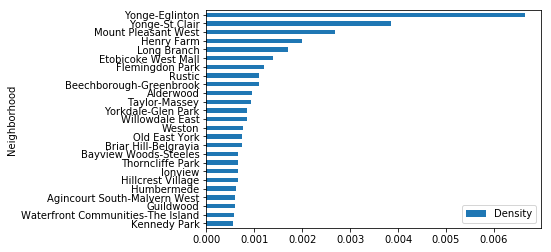

In [34]:
cluster0_explore.sort_values(by='Density',ascending=True).tail(25).plot.barh(x='Neighborhood',y='Density',rot=0)

### Conclusion <a name="concl"></a>

The data indicates that Waterfront Communities-The Island is an ideal neighborhood to open an artisanal coffee shop in Toronto. The following criteria laid out by the client have been met with this location.

1. Strong demand - The neighborhood has enough businesses/offices to support a loyal clientele plus this neighborhood  features high foot traffic areas, which is another advantage
2. A robust population - The neighborhood has 45,000+ working age residents with a high average income
3. Limited competition - The area has a low density of coffee shops compared to similar neighborhoods, but not so low as to create any doubts about the viability of an artisanal coffee shop in this area

Overall, Waterfront Communities-The Island is an ideal location to open a new artisanal coffee shop that meets all of the client's criteria and some more. Perhaps, a good location within the neighborhood is Queen's Quay Terminal, which could be further explored.